## Data Source:
https://www.kaggle.com/c/dogs-vs-cats/overview

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.python.platform import tf_logging as logging
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from datetime import datetime
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


In [2]:
# Set the path to your dataset
dataset_path = r'C:\Users\yashk\OneDrive\Desktop\Pace\SEM 3\Intro to DL\data\kagglecatsanddogs_5340\PetImages'

# Define parameters
batch_size = 32
image_size = (64, 64) 
input_shape = (64, 64, 3) 
epochs = 10

# DataFrame to store training results
results_df = pd.DataFrame(columns=['Model', 'Time', 'Train_Acc', 'Val_Acc', 'Train_Loss', 'Val_Loss','Test_Acc'])


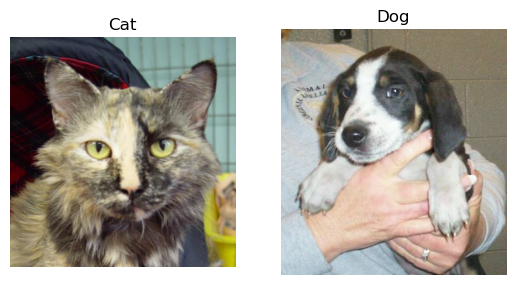

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Function to display one cat and one dog image
def display_sample_images(dataset_path):
    cat_path = os.path.join(dataset_path, 'Cat')
    dog_path = os.path.join(dataset_path, 'Dog')
    
    cat_files = [os.path.join(cat_path, filename) for filename in os.listdir(cat_path)]
    dog_files = [os.path.join(dog_path, filename) for filename in os.listdir(dog_path)]
    
    # Display one cat image
    cat_img = mpimg.imread(cat_files[2])
    plt.subplot(1, 2, 1)
    plt.imshow(cat_img)
    plt.title('Cat')
    plt.axis('off')
    
    # Display one dog image
    dog_img = mpimg.imread(dog_files[2])
    plt.subplot(1, 2, 2)
    plt.imshow(dog_img)
    plt.title('Dog')
    plt.axis('off')
    
    plt.show()

# Display sample images
display_sample_images(dataset_path)


# Tensorflow Keras CNN

In [4]:
# Build the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [5]:
# Load file paths and labels
file_paths = []
labels = []

for label in ['Cat', 'Dog']:
    folder_path = os.path.join(dataset_path, label)
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            # Try to open the image file
            img = Image.open(file_path)
            img.verify()  # Verify that it's a valid image
            file_paths.append(file_path)
            labels.append('Cat' if label == 'Cat' else 'Dog')
        except (IOError, SyntaxError, Image.DecompressionBombError, Image.UnidentifiedImageError):
            print(f"Skipping {file_path} due to an error.")

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(file_paths, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create a DataFrame for training, validation, and test sets
train_df = pd.DataFrame({'file_path': X_train, 'label': y_train})
val_df = pd.DataFrame({'file_path': X_val, 'label': y_val})
test_df = pd.DataFrame({'file_path': X_test, 'label': y_test})

Skipping C:\Users\yashk\OneDrive\Desktop\Pace\SEM 3\Intro to DL\data\kagglecatsanddogs_5340\PetImages\Cat\666.jpg due to an error.
Skipping C:\Users\yashk\OneDrive\Desktop\Pace\SEM 3\Intro to DL\data\kagglecatsanddogs_5340\PetImages\Cat\Thumbs.db due to an error.
Skipping C:\Users\yashk\OneDrive\Desktop\Pace\SEM 3\Intro to DL\data\kagglecatsanddogs_5340\PetImages\Dog\11702.jpg due to an error.
Skipping C:\Users\yashk\OneDrive\Desktop\Pace\SEM 3\Intro to DL\data\kagglecatsanddogs_5340\PetImages\Dog\Thumbs.db due to an error.


In [35]:
print(f"Training data size: {len(train_df)}")
print(f"Validation data size: {len(val_df)}")
print(f"Test data size: {len(test_df)}")

Training data size: 17498
Validation data size: 3750
Test data size: 3750


In [6]:
# Data Augmentation
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators for training, validation, and test sets
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df, x_col='file_path', y_col='label',
                                                    target_size=image_size, batch_size=batch_size, class_mode='binary')
val_generator = val_test_datagen.flow_from_dataframe(dataframe=val_df, x_col='file_path', y_col='label',
                                                    target_size=image_size, batch_size=batch_size, class_mode='binary')
test_generator = val_test_datagen.flow_from_dataframe(dataframe=test_df, x_col='file_path', y_col='label',
                                                      target_size=image_size, batch_size=batch_size, class_mode='binary')


Found 17498 validated image filenames belonging to 2 classes.
Found 3750 validated image filenames belonging to 2 classes.
Found 3750 validated image filenames belonging to 2 classes.


In [7]:
# Train the model and measure time
start_time = datetime.now()
history = model.fit(train_generator, epochs=epochs, validation_data=val_generator)
end_time = datetime.now()
elapsed_time = end_time - start_time



Epoch 1/10
547/547 [==============================] - 69s 124ms/step - loss: 0.6500 - accuracy: 0.6072 - val_loss: 0.5825 - val_accuracy: 0.7104
Epoch 2/10
547/547 [==============================] - 67s 123ms/step - loss: 0.5530 - accuracy: 0.7168 - val_loss: 0.4780 - val_accuracy: 0.7659
Epoch 3/10
547/547 [==============================] - 70s 127ms/step - loss: 0.4857 - accuracy: 0.7671 - val_loss: 0.4433 - val_accuracy: 0.7904
Epoch 4/10
547/547 [==============================] - 71s 130ms/step - loss: 0.4501 - accuracy: 0.7876 - val_loss: 0.4493 - val_accuracy: 0.7824
Epoch 5/10
547/547 [==============================] - 72s 131ms/step - loss: 0.4233 - accuracy: 0.8052 - val_loss: 0.4025 - val_accuracy: 0.8157
Epoch 6/10
547/547 [==============================] - 70s 127ms/step - loss: 0.3981 - accuracy: 0.8166 - val_loss: 0.3765 - val_accuracy: 0.8317
Epoch 7/10
547/547 [==============================] - 68s 124ms/step - loss: 0.3724 - accuracy: 0.8328 - val_loss: 0.3587 - val_ac

In [8]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy}, Test Loss: {test_loss}')



118/118 [==============================] - 8s 71ms/step - loss: 0.4064 - accuracy: 0.8256
Test Accuracy: 0.8256000280380249, Test Loss: 0.40642401576042175


In [9]:
# Store results in DataFrame
results_df.loc[len(results_df)] = ['Keras CNN', elapsed_time, history.history['accuracy'][-1],
                                   history.history['val_accuracy'][-1], history.history['loss'][-1],
                                   history.history['val_loss'][-1], test_accuracy]



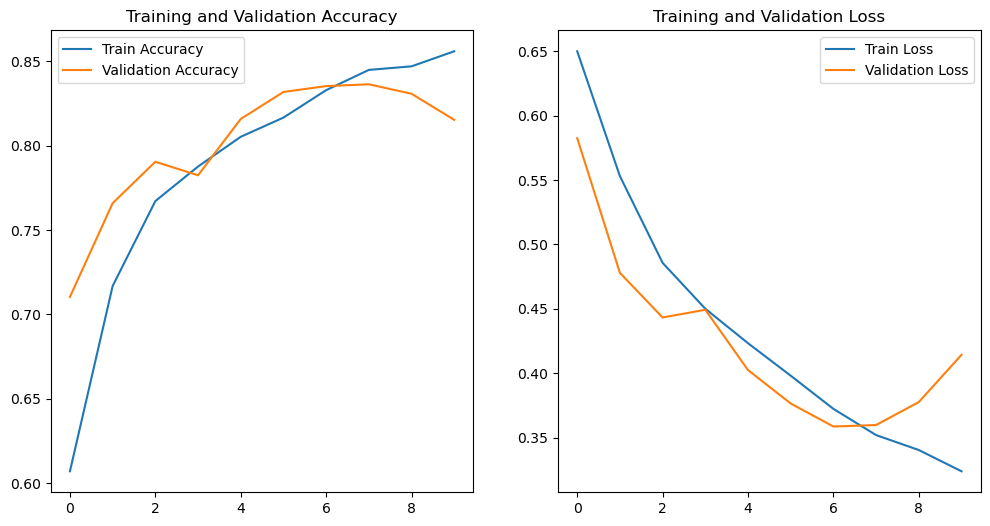

In [10]:
# Plot training and validation metrics
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()



In [11]:
# Display the results DataFrame
print(results_df)

       Model                   Time  Train_Acc  Val_Acc  Train_Loss  Val_Loss  \
0  Keras CNN 0 days 00:11:30.800596   0.855812   0.8152    0.323947  0.414341   

   Test_Acc  
0    0.8256  


118/118 [==============================] - 8s 69ms/step


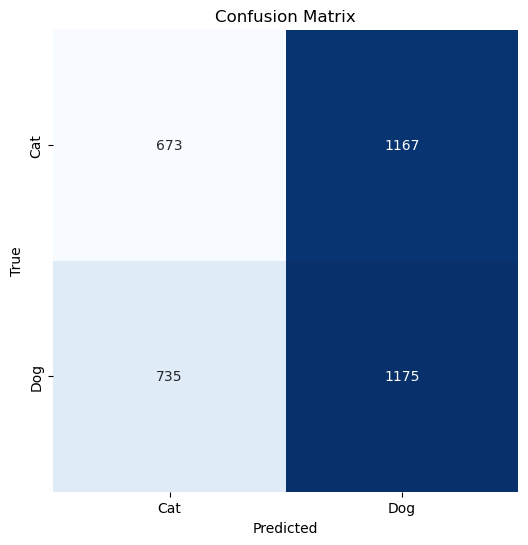

In [12]:
# Confusion Matrix

# Predict labels for the test set
y_pred = (model.predict(test_generator) > 0.5).astype(int)

# Get true labels
y_true = test_generator.classes

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Tensorflow MobileNetV2 Transfer Learning

In [13]:
from tensorflow.keras.applications import MobileNetV2


In [14]:
# Build MobileNetV2 model with transfer learning
base_model_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model_mobilenet.trainable = False

model_mobilenet = Sequential([
    base_model_mobilenet,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])
model_mobilenet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [15]:
# Train the MobileNetV2 model
start_time_mobilenet = datetime.now()
history_mobilenet = model_mobilenet.fit(train_generator, epochs=epochs, validation_data=val_generator)
end_time_mobilenet = datetime.now()
elapsed_time_mobilenet = end_time_mobilenet - start_time_mobilenet


Epoch 1/10
547/547 [==============================] - 73s 128ms/step - loss: 0.4843 - accuracy: 0.7604 - val_loss: 0.4274 - val_accuracy: 0.7989
Epoch 2/10
547/547 [==============================] - 68s 125ms/step - loss: 0.4326 - accuracy: 0.7930 - val_loss: 0.4295 - val_accuracy: 0.7907
Epoch 3/10
547/547 [==============================] - 69s 127ms/step - loss: 0.4124 - accuracy: 0.8046 - val_loss: 0.4192 - val_accuracy: 0.8048
Epoch 4/10
547/547 [==============================] - 70s 128ms/step - loss: 0.3952 - accuracy: 0.8125 - val_loss: 0.4053 - val_accuracy: 0.8141
Epoch 5/10
547/547 [==============================] - 70s 127ms/step - loss: 0.3820 - accuracy: 0.8196 - val_loss: 0.4102 - val_accuracy: 0.8096
Epoch 6/10
547/547 [==============================] - 68s 124ms/step - loss: 0.3753 - accuracy: 0.8275 - val_loss: 0.4021 - val_accuracy: 0.8187
Epoch 7/10
547/547 [==============================] - 70s 127ms/step - loss: 0.3682 - accuracy: 0.8319 - val_loss: 0.3988 - val_ac

In [16]:
# Evaluate the MobileNetV2 model on the test set
test_loss_mobilenet, test_accuracy_mobilenet = model_mobilenet.evaluate(test_generator)
print(f'MobileNetV2 Model Test Accuracy: {test_accuracy_mobilenet}, Test Loss: {test_loss_mobilenet}')

# Store results in DataFrame for InceptionV3 model
results_df.loc[len(results_df)] = ['MobileNetV2 Keras', elapsed_time_mobilenet,
                                   history_mobilenet.history['accuracy'][-1],
                                   history_mobilenet.history['val_accuracy'][-1],
                                   history_mobilenet.history['loss'][-1],
                                   history_mobilenet.history['val_loss'][-1],
                                   test_accuracy_mobilenet]



118/118 [==============================] - 10s 82ms/step - loss: 0.4240 - accuracy: 0.8112
MobileNetV2 Model Test Accuracy: 0.8112000226974487, Test Loss: 0.4240121841430664


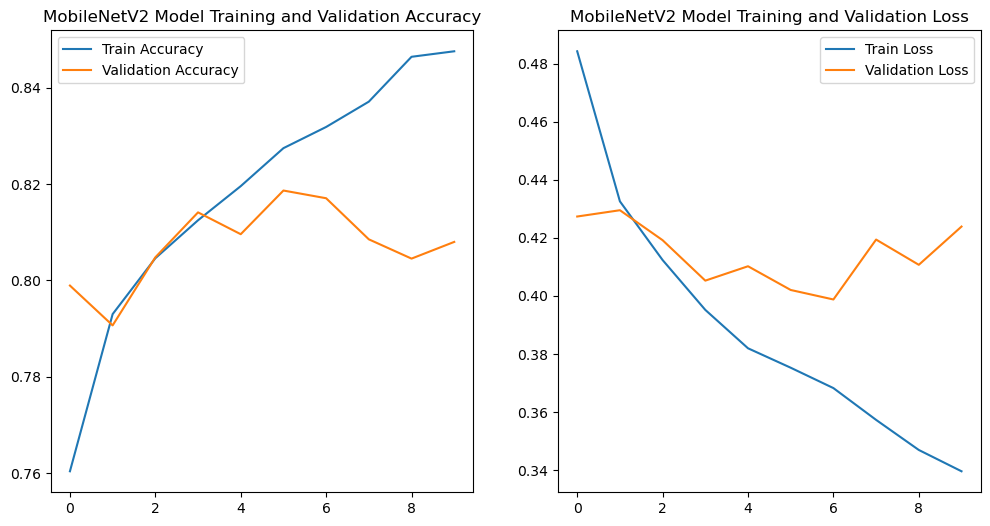

In [17]:
# Plot training and validation metrics for the MobileNetV2 model
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_mobilenet.history['accuracy'], label='Train Accuracy')
plt.plot(history_mobilenet.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('MobileNetV2 Model Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history_mobilenet.history['loss'], label='Train Loss')
plt.plot(history_mobilenet.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('MobileNetV2 Model Training and Validation Loss')

plt.show()

In [18]:
# Display the results DataFrame
results_df 

,Model,Time,Train_Acc,Val_Acc,Train_Loss,Val_Loss,Test_Acc
0,Keras CNN,0 days 00:11:30.800596,0.855812,0.8152,0.323947,0.414341,0.8256
1,MobileNetV2 Keras,0 days 00:11:37.497982,0.847583,0.8080,0.339582,0.423901,0.8112


118/118 [==============================] - 11s 81ms/step


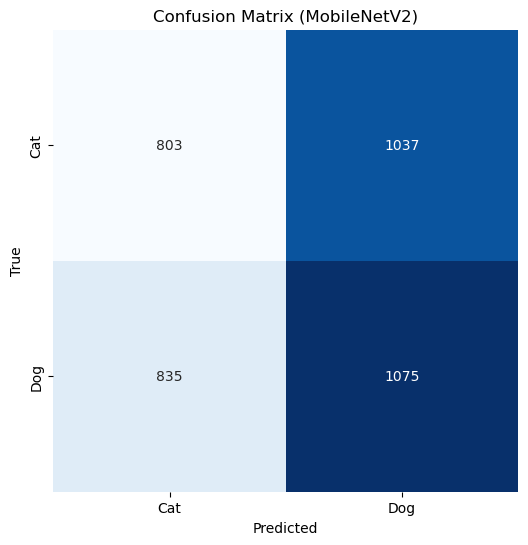

In [19]:
# Predict labels for the test set (MobileNetV2)
y_pred_mobilenetv2 = (model_mobilenet.predict(test_generator) > 0.5).astype(int)

# Get true labels
y_true_mobilenetv2 = test_generator.classes

# Calculate confusion matrix for MobileNetV2
cm_mobilenetv2 = confusion_matrix(y_true_mobilenetv2, y_pred_mobilenetv2)

# Plot confusion matrix for MobileNetV2
plt.figure(figsize=(6, 6))
sns.heatmap(cm_mobilenetv2, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices)
plt.title('Confusion Matrix (MobileNetV2)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Pytorch CNN

In [20]:
import torch.nn.functional as F
from tqdm import tqdm


In [21]:
train_df = pd.DataFrame({'file_path': X_train, 'label': y_train})
val_df = pd.DataFrame({'file_path': X_val, 'label': y_val})
test_df = pd.DataFrame({'file_path': X_test, 'label': y_test})

In [22]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd



# Define parameters
input_channels = 3  # RGB images

import torch
import torch.nn as nn

# Assuming label_mapping['Dog'] = 1 and label_mapping['Cat'] = 0
label_mapping = {'Dog': 1, 'Cat': 0}

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * (image_size[0] // 8) * (image_size[1] // 8), 128)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu4(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# Create an instance of the model
model_pytorch = ConvNet()

# Print the model architecture
print(model_pytorch)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_pytorch.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model_pytorch.parameters(), lr=0.001)

# Load file paths and labels
file_paths = []
labels = []

for label in ['Cat', 'Dog']:
    folder_path = os.path.join(dataset_path, label)
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            img = Image.open(file_path)
            img.verify()
            file_paths.append(file_path)
            labels.append(0 if label == 'Cat' else 1)
        except (IOError, SyntaxError, Image.DecompressionBombError, Image.UnidentifiedImageError):
            print(f"Skipping {file_path} due to an error.")

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]  # Assumes the file_path column is at index 0
        label = self.dataframe.iloc[idx, 1]     # Assumes the label column is at index 1

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Data transformations
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
])

# Create custom datasets and data loaders
train_dataset = CustomDataset(train_df, transform=transform)
val_dataset = CustomDataset(val_df, transform=transform)
test_dataset = CustomDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Skipping C:\Users\yashk\OneDrive\Desktop\Pace\SEM 3\Intro to DL\data\kagglecatsanddogs_5340\PetImages\Cat\666.jpg due to an error.
Skipping C:\Users\yashk\OneDrive\Desktop\Pace\SEM 3\Intro to DL\data\kagglecatsanddogs_5340\PetImages\Cat

In [23]:
# Train the PyTorch model and measure time
start_time = datetime.now()

train_loss_list = []  # List to store training loss for each epoch
train_accuracy_list = []  # List to store training accuracy for each epoch
val_loss_list = []  # List to store validation loss for each epoch
val_accuracy_list = []  # List to store validation accuracy for each epoch

for epoch in range(epochs):
    model_pytorch.train()
    total_loss = 0.0  # Initialize total loss for the epoch
    correct_train = 0
    total_train = 0

    # Use tqdm to display a progress bar
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{epochs}', unit='batch') as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), torch.tensor([label_mapping[label] for label in labels], dtype=torch.float32).unsqueeze(1).to(device)
            optimizer.zero_grad()
            outputs = model_pytorch(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Calculate training accuracy
            predictions = (outputs > 0.5).float()  # Threshold at 0.5 for binary classification
            correct_train += (predictions == labels).sum().item()
            total_train += labels.size(0)

            # Update the progress bar
            pbar.update(1)
            pbar.set_postfix({'Loss': loss.item()})

    # Calculate and print average loss and training accuracy for the epoch
    average_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {average_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    train_loss_list.append(average_loss)
    train_accuracy_list.append(train_accuracy)

    # Validation phase
    model_pytorch.eval()  # Set the model to evaluation mode
    correct_val = 0
    total_val = 0
    total_val_loss = 0.0  # Initialize total validation loss

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), torch.tensor([label_mapping[label] for label in labels], dtype=torch.float32).unsqueeze(1).to(device)
            outputs = model_pytorch(inputs)
            predictions = (outputs > 0.5).float()  # Threshold at 0.5 for binary classification
            correct_val += (predictions == labels).sum().item()
            total_val += labels.size(0)
            total_val_loss += criterion(outputs, labels).item()

    # Calculate and print validation accuracy
    val_accuracy = correct_val / total_val
    val_loss = total_val_loss / len(val_loader)
    print(f'Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {val_loss:.4f}')

    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_accuracy)

end_time = datetime.now()
elapsed_time = end_time - start_time

print(f"\nTraining Duration: {elapsed_time}")

Epoch 1/10: 100%|█████████████████████████████████████████████████████| 547/547 [01:37<00:00,  5.58batch/s, Loss=0.581]


Epoch [1/10], Loss: 0.6840, Train Accuracy: 0.5487
Validation Accuracy: 0.6645, Validation Loss: 0.6247


Epoch 2/10: 100%|█████████████████████████████████████████████████████| 547/547 [01:35<00:00,  5.75batch/s, Loss=0.441]


Epoch [2/10], Loss: 0.5810, Train Accuracy: 0.6977
Validation Accuracy: 0.7184, Validation Loss: 0.5609


Epoch 3/10: 100%|█████████████████████████████████████████████████████| 547/547 [01:37<00:00,  5.60batch/s, Loss=0.379]


Epoch [3/10], Loss: 0.5109, Train Accuracy: 0.7471
Validation Accuracy: 0.7600, Validation Loss: 0.4830


Epoch 4/10: 100%|█████████████████████████████████████████████████████| 547/547 [01:37<00:00,  5.62batch/s, Loss=0.373]


Epoch [4/10], Loss: 0.4616, Train Accuracy: 0.7821
Validation Accuracy: 0.7840, Validation Loss: 0.4552


Epoch 5/10: 100%|█████████████████████████████████████████████████████| 547/547 [01:38<00:00,  5.58batch/s, Loss=0.515]


Epoch [5/10], Loss: 0.4210, Train Accuracy: 0.8069
Validation Accuracy: 0.7995, Validation Loss: 0.4234


Epoch 6/10: 100%|█████████████████████████████████████████████████████| 547/547 [01:38<00:00,  5.55batch/s, Loss=0.487]


Epoch [6/10], Loss: 0.3829, Train Accuracy: 0.8303
Validation Accuracy: 0.8021, Validation Loss: 0.4186


Epoch 7/10: 100%|█████████████████████████████████████████████████████| 547/547 [01:36<00:00,  5.65batch/s, Loss=0.231]


Epoch [7/10], Loss: 0.3483, Train Accuracy: 0.8447
Validation Accuracy: 0.8208, Validation Loss: 0.3951


Epoch 8/10: 100%|███████████████████████████████████████████████████████| 547/547 [01:35<00:00,  5.72batch/s, Loss=0.4]


Epoch [8/10], Loss: 0.3078, Train Accuracy: 0.8674
Validation Accuracy: 0.8184, Validation Loss: 0.4053


Epoch 9/10: 100%|█████████████████████████████████████████████████████| 547/547 [01:36<00:00,  5.68batch/s, Loss=0.184]


Epoch [9/10], Loss: 0.2738, Train Accuracy: 0.8851
Validation Accuracy: 0.8203, Validation Loss: 0.3945


Epoch 10/10: 100%|████████████████████████████████████████████████████| 547/547 [01:36<00:00,  5.67batch/s, Loss=0.374]


Epoch [10/10], Loss: 0.2367, Train Accuracy: 0.9019
Validation Accuracy: 0.8109, Validation Loss: 0.4737

Training Duration: 0:18:42.815508


In [24]:
# Evaluate the PyTorch model on the test set
model_pytorch.eval()
correct_test  = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), torch.tensor([label_mapping[label] for label in labels], dtype=torch.float32).unsqueeze(1).to(device)
        outputs = model_pytorch(inputs)
        predicted = torch.round(outputs)
        total_test += labels.size(0)
        correct_test += (predicted == labels.view(-1, 1)).sum().item()

test_accuracy = correct_test / total_test
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')




Test Accuracy: 80.67%


In [26]:
# Store results in DataFrame
results_df.loc[len(results_df)] = ['PyTorch Model', elapsed_time, train_accuracy, val_accuracy, average_loss, val_loss, test_accuracy]
# Display the results DataFrame
results_df

,Model,Time,Train_Acc,Val_Acc,Train_Loss,Val_Loss,Test_Acc
0,Keras CNN,0 days 00:11:30.800596,0.855812,0.815200,0.323947,0.414341,0.825600
1,MobileNetV2 Keras,0 days 00:11:37.497982,0.847583,0.808000,0.339582,0.423901,0.811200
2,PyTorch Model,0 days 00:18:42.815508,0.901874,0.810933,0.236673,0.473708,0.806667


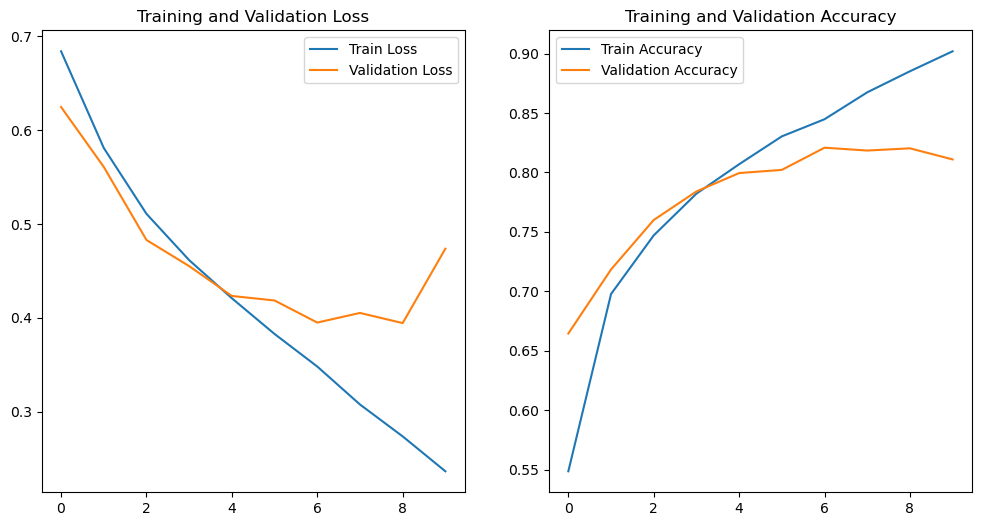

In [27]:
# Plot training and validation metrics
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_list, label='Train Accuracy')
plt.plot(val_accuracy_list, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

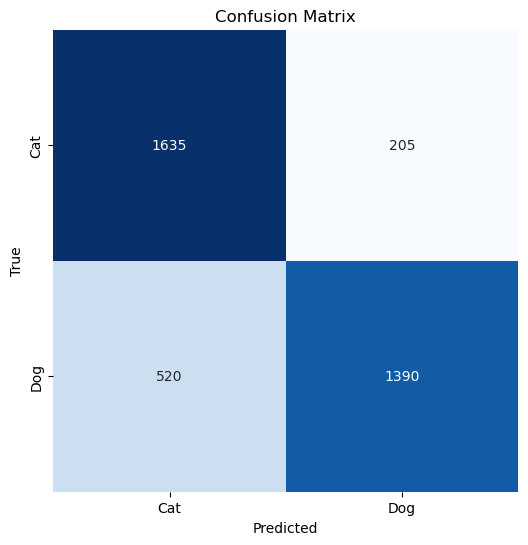

In [28]:
y_true_pytorch = []
y_pred_pytorch = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), torch.tensor([label_mapping[label] for label in labels], dtype=torch.float32).unsqueeze(1).to(device)
        outputs = model_pytorch(inputs)
        predicted = torch.round(outputs)

        y_true_pytorch.extend(labels.cpu().numpy())
        y_pred_pytorch.extend(predicted.cpu().numpy())



# Convert lists to numpy arrays
y_true_pytorch = np.array(y_true_pytorch)
y_pred_pytorch = np.array(y_pred_pytorch)

# Calculate confusion matrix
cm_pytorch = confusion_matrix(y_true_pytorch, y_pred_pytorch)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm_pytorch, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Cat', 'Dog'],
            yticklabels=['Cat', 'Dog'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Pytorch Mobile V2 Transfer Learning

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Assuming you have a dataset and DataLoader for training and validation
# train_loader and val_loader are assumed to be your DataLoader instances

# Define MobileNetV2 model
class MobileNetV2(nn.Module):
    def __init__(self, num_classes=1):
        super(MobileNetV2, self).__init__()
        # Define the MobileNetV2 architecture
        self.mobilenet_v2 = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
        # Adjust the classifier for binary classification
        in_features = self.mobilenet_v2.classifier[1].in_features
        self.mobilenet_v2.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.mobilenet_v2(x)

# Create an instance of the MobileNetV2 model
model_mobilenetv2 = MobileNetV2()

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_mobilenetv2.parameters(), lr=0.001)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_mobilenetv2.to(device)

Using cache found in C:\Users\yashk/.cache\torch\hub\pytorch_vision_v0.10.0


MobileNetV2(
  (mobilenet_v2): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_si

In [30]:
# Train the MobileNetV2 model and measure time
start_time = datetime.now()

for epoch in range(epochs):
    model_mobilenetv2.train()
    total_loss = 0.0  # Initialize total loss for the epoch
    correct_train = 0
    total_train = 0

    # Use tqdm to display a progress bar
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{epochs}', unit='batch') as pbar:
        for data in train_loader: 
            inputs, labels = data[0].to(device), torch.tensor([label_mapping[label] for label in data[1]], dtype=torch.float32).unsqueeze(1).to(device)
            optimizer.zero_grad()
            outputs = model_mobilenetv2(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Calculate training accuracy
            predictions = (torch.sigmoid(outputs) > 0.5).float()  # Threshold at 0.5 for binary classification
            correct_train += (predictions == labels).sum().item()
            total_train += labels.size(0)

            # Update the progress bar
            pbar.update(1)
            pbar.set_postfix({'Loss': loss.item()})

    # Calculate and print average loss and training accuracy for the epoch
    average_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {average_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    # Validation phase
    model_mobilenetv2.eval()  # Set the model to evaluation mode
    correct_val = 0
    total_val = 0
    total_val_loss = 0.0  # Initialize total validation loss

    with torch.no_grad():
        for data in val_loader:  
            inputs, labels = data[0].to(device), torch.tensor([label_mapping[label] for label in data[1]], dtype=torch.float32).unsqueeze(1).to(device)
            outputs = model_mobilenetv2(inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            # Calculate validation accuracy
            predictions = (torch.sigmoid(outputs) > 0.5).float()  # Threshold at 0.5 for binary classification
            correct_val += (predictions == labels).sum().item()
            total_val += labels.size(0)

    # Calculate and print validation accuracy and loss
    val_accuracy = correct_val / total_val
    val_loss = total_val_loss / len(val_loader)
    print(f'Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {val_loss:.4f}')

end_time = datetime.now()
elapsed_time = end_time - start_time

print(f"\nTraining Duration: {elapsed_time}")

Epoch 1/10: 100%|██████████████████████████████████████████████████████| 547/547 [03:28<00:00,  2.63batch/s, Loss=0.49]


Epoch [1/10], Loss: 0.3255, Train Accuracy: 0.8604
Validation Accuracy: 0.9107, Validation Loss: 0.2331


Epoch 2/10: 100%|█████████████████████████████████████████████████████| 547/547 [03:30<00:00,  2.59batch/s, Loss=0.107]


Epoch [2/10], Loss: 0.2165, Train Accuracy: 0.9124
Validation Accuracy: 0.9264, Validation Loss: 0.1969


Epoch 3/10: 100%|██████████████████████████████████████████████████████| 547/547 [03:33<00:00,  2.56batch/s, Loss=0.28]


Epoch [3/10], Loss: 0.1786, Train Accuracy: 0.9302
Validation Accuracy: 0.9123, Validation Loss: 0.2089


Epoch 4/10: 100%|████████████████████████████████████████████████████| 547/547 [03:38<00:00,  2.50batch/s, Loss=0.0774]


Epoch [4/10], Loss: 0.1509, Train Accuracy: 0.9417
Validation Accuracy: 0.9200, Validation Loss: 0.2015


Epoch 5/10: 100%|████████████████████████████████████████████████████| 547/547 [03:30<00:00,  2.60batch/s, Loss=0.0814]


Epoch [5/10], Loss: 0.1227, Train Accuracy: 0.9525
Validation Accuracy: 0.9163, Validation Loss: 0.2099


Epoch 6/10: 100%|█████████████████████████████████████████████████████| 547/547 [03:38<00:00,  2.50batch/s, Loss=0.304]


Epoch [6/10], Loss: 0.1128, Train Accuracy: 0.9575
Validation Accuracy: 0.9099, Validation Loss: 0.2545


Epoch 7/10: 100%|██████████████████████████████████████████████████████| 547/547 [03:37<00:00,  2.52batch/s, Loss=0.13]


Epoch [7/10], Loss: 0.1020, Train Accuracy: 0.9623
Validation Accuracy: 0.9061, Validation Loss: 0.2312


Epoch 8/10: 100%|█████████████████████████████████████████████████████| 547/547 [03:37<00:00,  2.51batch/s, Loss=0.117]


Epoch [8/10], Loss: 0.0876, Train Accuracy: 0.9655
Validation Accuracy: 0.9208, Validation Loss: 0.2142


Epoch 9/10: 100%|████████████████████████████████████████████████████| 547/547 [03:34<00:00,  2.55batch/s, Loss=0.0598]


Epoch [9/10], Loss: 0.0836, Train Accuracy: 0.9702
Validation Accuracy: 0.9211, Validation Loss: 0.2380


Epoch 10/10: 100%|███████████████████████████████████████████████████| 547/547 [03:30<00:00,  2.59batch/s, Loss=0.0395]


Epoch [10/10], Loss: 0.0730, Train Accuracy: 0.9724
Validation Accuracy: 0.9219, Validation Loss: 0.2173

Training Duration: 0:38:35.691613


In [40]:
# Test the MobileNetV2 model
model_mobilenetv2.eval()  # Set the model to evaluation mode
correct_test = 0
total_test = 0
total_test_loss = 0.0  # Initialize total test loss
all_true_labels = []
all_predicted_labels = []

with torch.no_grad():
    for data in test_loader:  # Change this line to iterate over data
        inputs, labels = data[0].to(device), torch.tensor([label_mapping[label] for label in data[1]], dtype=torch.float32).unsqueeze(1).to(device)
        outputs = model_mobilenetv2(inputs)
        loss = criterion(outputs, labels)
        total_test_loss += loss.item()

        # Calculate test accuracy
        predicted = torch.round(torch.sigmoid(outputs))
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)
        
        # Append true and predicted labels to the lists
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

# Calculate and print test accuracy and loss
test_accuracy = correct_test / total_test
test_loss = total_test_loss / len(test_loader)
print(f'Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}')

# Convert lists to numpy arrays
all_true_labels = np.array(all_true_labels)
all_predicted_labels = np.array(all_predicted_labels)


# Store results in DataFrame
results_df.loc[len(results_df)] = ['MobileNetV2', elapsed_time, train_accuracy, val_accuracy, average_loss, val_loss, test_accuracy]


Test Accuracy: 0.9216, Test Loss: 0.2337


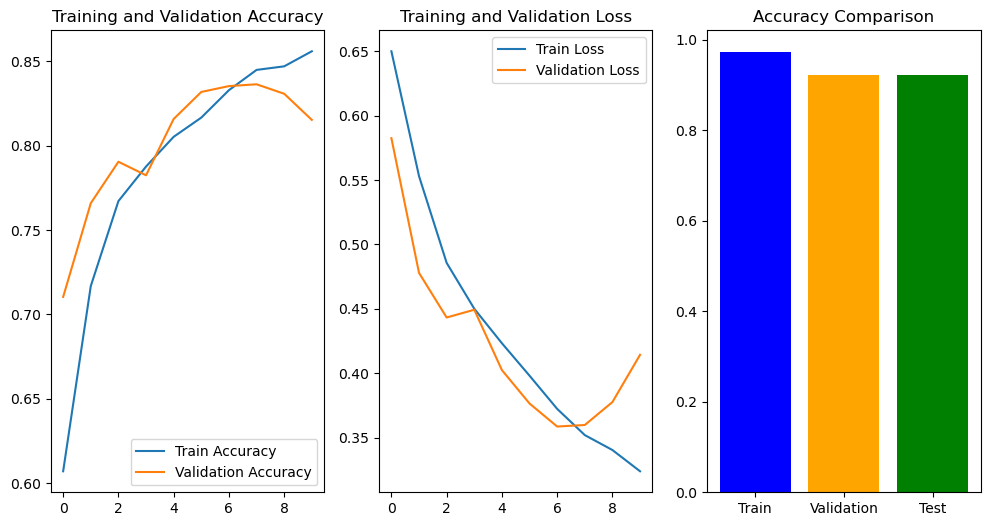

In [41]:
# Plot training and validation metrics
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 3)
plt.bar(['Train', 'Validation', 'Test'], [train_accuracy, val_accuracy, test_accuracy], color=['blue', 'orange', 'green'])
plt.title('Accuracy Comparison')

plt.show()



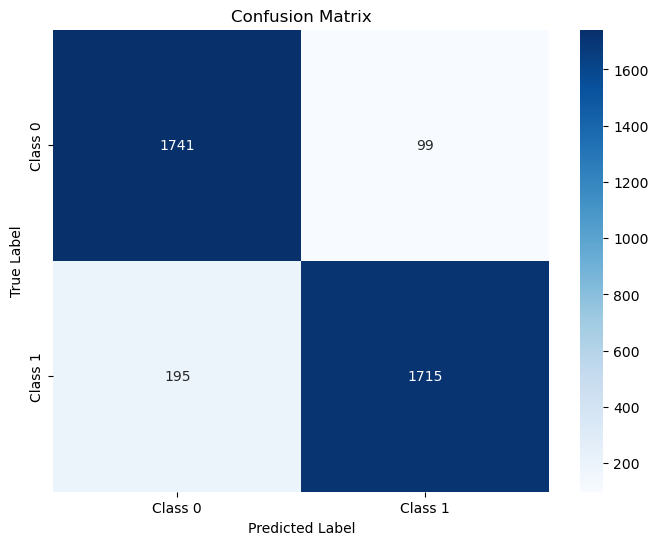

In [43]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Comparitive Metrics for All Models

In [69]:
# Display the results DataFrame
# converting to minutes and seconds
results_df['Time'] = results_df['Time'].dt.total_seconds().astype(int).apply(lambda x: '{:02}:{:02}'.format(int(x // 60), int(x % 60)))
# Model Parameters
results_df['# Parameters']= [model.count_params(),model_mobilenet.count_params(), sum(p.numel() for p in model_pytorch.parameters()), sum(p.numel() for p in model_mobilenetv2.parameters())]

In [71]:
results_df 

,Model,Time,Train_Acc,Val_Acc,Train_Loss,Val_Loss,Test_Acc,# Parameters
0,Keras CNN,11:30,0.855812,0.815200,0.323947,0.414341,0.825600,683329
1,MobileNetV2 Keras,11:37,0.847583,0.808000,0.339582,0.423901,0.811200,2422081
2,PyTorch Model,18:42,0.901874,0.810933,0.236673,0.473708,0.806667,1142081
3,MobileNetV2,38:35,0.972397,0.921867,0.073038,0.217328,0.921600,2225153
